# Machine Learning with Spark and Caché

[Apache Spark](http://spark.apache.org/) has rapidly become one of the most exciting technologies for big data analytics and machine learning. Spark is a general data processing engine created for use in clustered computing environments. It's heart is the Resilient Distributed Dataset (RDD) which represents a distributed, fault tolerant, collection of data that can be operated on in parallel across the nodes of a cluster. Spark is implemented using a combination of Java and Scala and so comes as a library that can run on any JVM. Spark also supports Python (PySpark) and R (SparkR) and includes libraries for SQL (SparkSQL), machine learning (MLlib), graph processing (GraphX), and stream processing (Spark Streaming). 

When the Cach&eacute; Spark connector is released, Spark-based applications will be able to make full use of Caché as an open analytics platform. That means taking full advantage of the capabilities of the underlying Cach&eacute; database by optimizing throughput through parallelization and pushing down appropriate filtering work to the database, minimizing the amount of data that needs to be read. However, today using a plain JDBC connection to Cach&eacute;, we can already begin using Spark with Cach&eacute; and then transparently upgrade to the new connector when it becomes available.

The following is my attempt to demonstrate a machine learning &quot;Hello World&quot; using Spark and Cach&eacute; running locally on my laptop. I show a couple of machine learning examples (linear regression and naive Bayes classification) using PySpark and a JDBC connection to  Cach&eacute;. Conveniently, Cach&eacute;&apos;s SAMPLES namespace contains a copy of the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), one of the classics for machine learning demonstrations. 


## Setting up Spark and Cach&eacute; on my Windows laptop
To install Spark locally on my laptop, I essentially followed the steps outlined here: [How to run Apache Spark on Windows 7 in Standalone Mode](http://nishutayaltech.blogspot.in/2015/04/how-to-run-apache-spark-on-windows7-in.html)
Here are some details:
* Java 1.8
* Note: I did not install Scala separately as described in the above article. The pre-built Spark libraries I installed already contained the Scala executables and jars.
* Python 2.7.12. I installed this as part of the Anaconda 4.2 package.
* Spark version 2.6. Prebuilt package for Hadoop.
* findspark python package. I installed this using pip install findspark. This package uses the SPARK_HOME environment variable   to locate the Spark installation. This makes it easier to import Spark into python code.
* Environment variables:
    * SPARK_HOME: pointing to the spark installation directory.
    * HADOOP_HOME: pointing to the Hadoop installation directory. Note that winutils.exe must be installed in the bin 
      subdirectory. The above article discusses this dependency and provides a link for downloading the file.
* Directories: c:\spark\temp
      
Here is my Cach&eacute; setup:
* Cach&eacute; 2016.2.1
* I configured the following environment variable so that python would be able to find the Cach&eacute; jdbc driver:
    * SPARK_CLASSPATH: cache-install-dir\dev\lib\java\lib\jdk18\cachejdbc.jar
*  To prepare the Iris dataset, I ran the following Cach&eacute; command in the SAMPLES namespace:
  ```
  SAMPLES>Do ##class(DataMining.IrisDataset).load()
  ``` 


You can execute the following code samples from the command line. Open your [spark installation]/bin directory and enter &quot;pyspark&quot;. You should see output like the following:
<img src="pyspark.png">


I wrote this entire article, inlcuding all the code samples, in a jupyter notebook. You can get this on GitHub [well not yet but hopefully soon]. Once your environment is ready you can launch the notebook and execute all the code samples directly from within it.

First we'll use findspark to do a quick test to verify that Spark is correctly configured and that we can import it into our environment.

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()
# If the Spark context was created, we should see output that looks something like <pyspark.context.SparkContext at 0x2b2aeb8>
sc

## Loading and Examining Some Data
Next we will create a SparkSession instance and use it to connect to Cach&eacute;. SparkSession is the starting point for using Spark. We will use it to load the Iris dataset into a Spark DataFrame. The Spark DataFrame extends the functionality of the original Spark RDD (discussed above). In addition to many optimizations, the DataFrame adds the ability to access and manipulate data through both a relational sql-like interface and a list of objects.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local")
spark = SparkSession.builder.config('spark.sql.warehouse.dir','file:///C:/spark/temp')
spark = SparkSession.builder.getOrCreate()
iris = spark.read.format("jdbc").option("url","jdbc:Cache://localhost:1972/SAMPLES").option("driver",
"com.intersys.jdbc.CacheDriver").option("dbtable","DataMining.IrisDataset").option("user",
"_System").option("password","SYS").option("spark.sql.warehouse.dir","file:///C:/spark/temp").load()

Here we can run a command to display the first 10 rows of Iris data as a table.

In [3]:
iris.show(10)

+---+-----------+----------+-----------+----------+-----------+
| ID|PetalLength|PetalWidth|SepalLength|SepalWidth|    Species|
+---+-----------+----------+-----------+----------+-----------+
|  1|        1.4|       0.2|        5.1|       3.5|Iris-setosa|
|  2|        1.4|       0.2|        4.9|       3.0|Iris-setosa|
|  3|        1.3|       0.2|        4.7|       3.2|Iris-setosa|
|  4|        1.5|       0.2|        4.6|       3.1|Iris-setosa|
|  5|        1.4|       0.2|        5.0|       3.6|Iris-setosa|
|  6|        1.7|       0.4|        5.4|       3.9|Iris-setosa|
|  7|        1.4|       0.3|        4.6|       3.4|Iris-setosa|
|  8|        1.5|       0.2|        5.0|       3.4|Iris-setosa|
|  9|        1.4|       0.2|        4.4|       2.9|Iris-setosa|
| 10|        1.5|       0.1|        4.9|       3.1|Iris-setosa|
+---+-----------+----------+-----------+----------+-----------+
only showing top 10 rows



By the way, a sepal is a leaf, usually green, that serves to protect a flower in its bud stage and then physically support the flower when it blooms.

We can do a variety of SQL-like operations, for example finding the number rows where PetalLength is greater than 6.0 or finding the counts of the different species:

In [4]:
iris.filter(iris["PetalLength"]>6.0).show()
iris.groupBy("Species").count().show()

+---+-----------+----------+-----------+----------+--------------+
| ID|PetalLength|PetalWidth|SepalLength|SepalWidth|       Species|
+---+-----------+----------+-----------+----------+--------------+
|106|        6.6|       2.1|        7.6|       3.0|Iris-virginica|
|108|        6.3|       1.8|        7.3|       2.9|Iris-virginica|
|110|        6.1|       2.5|        7.2|       3.6|Iris-virginica|
|118|        6.7|       2.2|        7.7|       3.8|Iris-virginica|
|119|        6.9|       2.3|        7.7|       2.6|Iris-virginica|
|123|        6.7|       2.0|        7.7|       2.8|Iris-virginica|
|131|        6.1|       1.9|        7.4|       2.8|Iris-virginica|
|132|        6.4|       2.0|        7.9|       3.8|Iris-virginica|
|136|        6.1|       2.3|        7.7|       3.0|Iris-virginica|
|256|        6.6|       2.1|        7.6|       3.0|Iris-virginica|
|258|        6.3|       1.8|        7.3|       2.9|Iris-virginica|
|260|        6.1|       2.5|        7.2|       3.6|Iris-virgin

Here are the first 10 rows displayed as a python list of Spark Row objects:

In [5]:
iris.head(10)

[Row(ID=1, PetalLength=1.4, PetalWidth=0.2, SepalLength=5.1, SepalWidth=3.5, Species=u'Iris-setosa'),
 Row(ID=2, PetalLength=1.4, PetalWidth=0.2, SepalLength=4.9, SepalWidth=3.0, Species=u'Iris-setosa'),
 Row(ID=3, PetalLength=1.3, PetalWidth=0.2, SepalLength=4.7, SepalWidth=3.2, Species=u'Iris-setosa'),
 Row(ID=4, PetalLength=1.5, PetalWidth=0.2, SepalLength=4.6, SepalWidth=3.1, Species=u'Iris-setosa'),
 Row(ID=5, PetalLength=1.4, PetalWidth=0.2, SepalLength=5.0, SepalWidth=3.6, Species=u'Iris-setosa'),
 Row(ID=6, PetalLength=1.7, PetalWidth=0.4, SepalLength=5.4, SepalWidth=3.9, Species=u'Iris-setosa'),
 Row(ID=7, PetalLength=1.4, PetalWidth=0.3, SepalLength=4.6, SepalWidth=3.4, Species=u'Iris-setosa'),
 Row(ID=8, PetalLength=1.5, PetalWidth=0.2, SepalLength=5.0, SepalWidth=3.4, Species=u'Iris-setosa'),
 Row(ID=9, PetalLength=1.4, PetalWidth=0.2, SepalLength=4.4, SepalWidth=2.9, Species=u'Iris-setosa'),
 Row(ID=10, PetalLength=1.5, PetalWidth=0.1, SepalLength=4.9, SepalWidth=3.1, Spec

The following code acccesses the Iris data through the list interface to create a pair of arrays to use with the matplotlib charting library. Spark unfortunately does not have its own charting library. The code creates a scatter plot showing PetalLength vs. PetalWidth.

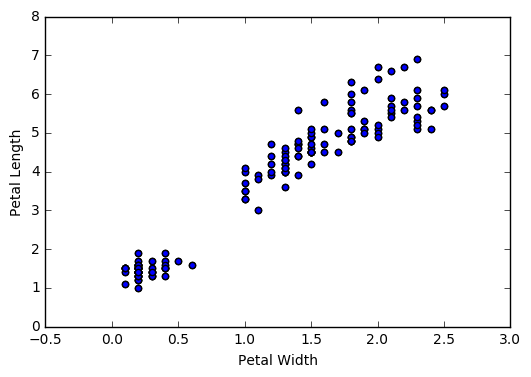

In [6]:
import matplotlib.pyplot as plt

#Retrieve an array of row objects from the DataFrame
items = iris.collect()
petal_length = []
petal_width = []
for item in items:
    petal_length.append(item['PetalLength'])
    petal_width.append(item['PetalWidth'])

plt.scatter(petal_width,petal_length)
plt.xlabel("Petal Width")
plt.ylabel("Petal Length")
plt.show()

## Training and Testing a Linear Regression Model
Looks like there is a pretty strong linear relationship between PetalWidth and PetalLength. I suppose that&apos;s not surprising. Let&apos;s investigate the relationship more closely using Spark's machine learning library. We will train a simple linear regression model to fit a line through the data. Once we have the model we can use it to predict the length of an Iris petal based on its width.

Here is an outline of the steps in the following code:

1. Create a new DataFrame and transform the PetalWidth or "features" column into the vector needed by the Spark library.
2. Randomly divide the Iris data into training (70%) and test (30%) sets.
3. Use the training data to fit a linear regression model, the actual machine learning.
4. Run the test data through the model and display the result.

In [7]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Transform the "Features" column(s) into the correct vector format
df = iris.select('PetalLength','PetalWidth')
vectorAssembler = VectorAssembler(inputCols=["PetalWidth"],
                                  outputCol="features")
data=vectorAssembler.transform(df)   

# Split the data into training and test sets.
trainingData,testData = data.randomSplit([0.7, 0.3], 0.0)

# Configure the model.
lr = LinearRegression().setFeaturesCol("features").setLabelCol("PetalLength").setMaxIter(10)

# Train the model using the training data.
lrm = lr.fit(trainingData)

# Run the test data through the model and display its predictions for PetalLength.
predictions = lrm.transform(testData)
predictions.show()


+-----------+----------+--------+------------------+
|PetalLength|PetalWidth|features|        prediction|
+-----------+----------+--------+------------------+
|        1.0|       0.2|   [0.2]|1.5653385837963045|
|        1.1|       0.1|   [0.1]|1.3456666610929295|
|        1.2|       0.2|   [0.2]|1.5653385837963045|
|        1.2|       0.2|   [0.2]|1.5653385837963045|
|        1.2|       0.2|   [0.2]|1.5653385837963045|
|        1.3|       0.3|   [0.3]|1.7850105064996793|
|        1.4|       0.1|   [0.1]|1.3456666610929295|
|        1.4|       0.1|   [0.1]|1.3456666610929295|
|        1.4|       0.2|   [0.2]|1.5653385837963045|
|        1.4|       0.2|   [0.2]|1.5653385837963045|
|        1.4|       0.2|   [0.2]|1.5653385837963045|
|        1.4|       0.2|   [0.2]|1.5653385837963045|
|        1.4|       0.3|   [0.3]|1.7850105064996793|
|        1.4|       0.3|   [0.3]|1.7850105064996793|
|        1.5|       0.1|   [0.1]|1.3456666610929295|
|        1.5|       0.1|   [0.1]|1.34566666109

The prediction column shows the petal length predicted by the model. We can compare it to the actual values in the PetalLength column. 

The next piece of code evaluates the model by calculating the root mean squared error (RMSE) for its predictions on the test data. This provides one measure of the model&apos;s accuracy. The code also retrieves the slope and y-intercept of the regression line. We will use this to add the regression line to our earlier scatter plot.

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator

# retrieve the slope and y-intercepts of the regression line from the model.
slope = lrm.coefficients[0]
intercept = lrm.intercept

print("slope of regression line: %s" % str(slope))
print("y-intercept of regression line: %s" % str(intercept))


# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="PetalLength", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


slope of regression line: 2.19671922703
y-intercept of regression line: 1.12599473839
Root Mean Squared Error (RMSE) on test data = 0.401258


Based on this RMSE value it is not perfectly clear to me how well our model does at predicting petal length. We can compare the error to the average PetalLength value and perhaps get some sense of the error&apos;s significance.

In [10]:
iris.describe(["PetalLength"]).show()

+-------+-----------------+
|summary|      PetalLength|
+-------+-----------------+
|  count|              300|
|   mean|3.758666666666666|
| stddev|1.761467412995684|
|    min|              1.0|
|    max|              6.9|
+-------+-----------------+



Finally, let&apos;s visualize the model by adding the regression line determined by the above slope and intercept to our original scatter plot.

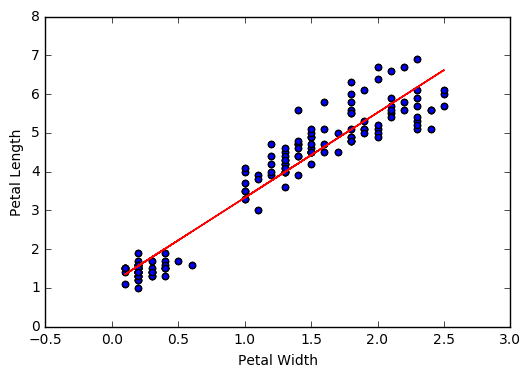

In [9]:
import matplotlib.pyplot as plt

items = iris.collect()
petal_length = []
petal_width = []
petal_features = []
for item in items:
    petal_length.append(item['PetalLength'])
    petal_width.append(item['PetalWidth'])
fig, ax = plt.subplots()
ax.scatter(petal_width,petal_length)
plt.xlabel("Petal Width")
plt.ylabel("Petal Length")
y = [slope*x+intercept for x in petal_width]
ax.plot(petal_width, y, color='red')

plt.show()

## Training and Testing a Classification Model
The Iris data contains three different species of Iris: Iris-Setosa, Iris-Verisicolor, and Iris-Virginica. We can train a model to classify or predict which species a flower belongs to based on its features: PetalLength, PetalWidth, SepalLength, and SepalWidth. Spark supports several different classification algorithms. The following code uses the Naive Bayes algorithm, one of the simpler yet still very powerful classification algorithms.

Here is an outline of the steps:
1. Prepare the data for the model. This involves putting the features into a vector. It also involves indexing the classes, replacing "Iris-Setosa" with 0.0, "Iris-verisicolor" with 1.0, and "Iris-Virginica" with 2.0.
2. Randomly divide the Iris data into training (70%) and test (30%) sets.
3. Train the classifier on the training data.
4. Run the test data through the model to generate predicted classifications
5. Un-index the predictions so we can see the species names rather than the indexes in the output.
6. Display the actual and predicted species side-by-side.

In [10]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import StringIndexer,IndexToString

# Prepare the data by indexing the classes and putting the features into a vector.
speciesIndexer = StringIndexer(inputCol="Species", outputCol="speciesIndex")
vectorAssembler = VectorAssembler(inputCols=["PetalWidth","PetalLength","SepalWidth","SepalLength"],
                                  outputCol="features")

data = vectorAssembler.transform(iris)
index_model = speciesIndexer.fit(data)
data_indexed = index_model.transform(data)

# Split the data into training and test sets.
trainingData, testData =  data_indexed.randomSplit([0.7, 0.3],0.0)

# Configure the classifier and then train it using the training set.
nb = NaiveBayes().setFeaturesCol("features").setLabelCol("speciesIndex").setSmoothing(1.0).setModelType("multinomial")
model = nb.fit(trainingData)

# Run the classifier on the test set
classifications = model.transform(testData)

# Un-index the data so we have the species names rather than the index numbers in our output.
converter = IndexToString(inputCol="prediction", outputCol="PredictedSpecies", labels=index_model.labels)
converted = converter.transform(classifications)

# Display the actual and predicted species side-by-side
converted.select(['Species','PredictedSpecies']).show(45)


+---------------+----------------+
|        Species|PredictedSpecies|
+---------------+----------------+
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|    Iris-setosa|     Iris-setosa|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor| Iris-versicolor|
|Iris-versicolor|  Iris-virginica|
|Iris-versicolor|  Iris-virginica|
|Iris-versicolor| Ir

You can see that the classifier was not perfect. In the above subset of the data it misclassified two of the Iris-Verisicolor and one of the Iris-Virginica's. We can use an evaluator to calculate the exact accuracy of the classifier on the test data.

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="speciesIndex", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(classifications)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.936708860759


If this accuracy is not sufficient, we could tune some parameters of the model or even try an entirely different classification algorithm.